In [197]:
import matplotlib, cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import glob
import math
import random
from scipy import ndimage
%matplotlib inline

In [198]:
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))

In [199]:
def load_training_images(n):
        images = np.full([n], None)
        names = np.full([n], str)
        i = 0
        for name in glob.glob('dataset1/training/png/*.png'):
            images[i] = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
            names[i] = name[26:len(name)-4]
            i += 1
        return [images, names]

In [200]:
def generate_pyramids(templates):
    n = len(templates)
    octaves = 3
    spo = 2 # scales per octave
    nscales = (octaves * spo) + 1
    template_size = 512
    scale_factor = (1 /(2 ** (1 / spo))) 
    sigma = round(scale_factor / math.pi, 2)
    pyramids = np.full((n), np.array)
    
    for i in range(n):
        pyramid = np.full((nscales), np.array)
        for j in range(nscales):
            if j == 0:
                pyramid[0] = cv2.cvtColor(templates[i], cv2.COLOR_RGB2GRAY)
                size = template_size
            else:
                size = round(size * scale_factor)
                temp = cv2.GaussianBlur(pyramid[j - 1], [0, 0], sigmaX = sigma)
                pyramid[j] = cv2.resize(temp, [size, size])
        pyramids[i] = pyramid
    return pyramids

In [201]:
def slowsimilarity(img1, img2):
    if(not len(img1) == len(img2) or not len(img1[0]) == len(img2[0])):
        print("Incompatible sizes")
        return
    acc = 0
    for i in range(len(img1)):
        for j in range(len(img1[0])):
            acc += abs(int(img1[i][j]) - int(img2[i][j]))
    return acc / (len(img1) ** 2)

In [202]:
def quicksimilarity(img1, img2):
    quality = 6
    if(not len(img1) == len(img2) or not len(img1[0]) == len(img2[0])):
        print("Incompatible sizes")
        return
    acc = 0
    for i in range(quality):
        for j in range(quality):
            x = int((i / quality) * len(img1))
            y = int((j / quality) * len(img1[0]))
            acc += abs(int(img1[x][y]) - int(img2[x][y]))
    return acc / (quality ** 2)

In [377]:
def detect_image(template, testimage):
    nscales = 7
    basesize = len(testimage)
    bestscore = 256
    xpos = []
    ypos = []
    scores = []
    templates = []
    candsize = basesize
    skipnext = False
    o_dscale = 2
    
    for s in range(nscales):
        if(s < 5): dscale = o_dscale * 4
        elif(s < 6): dscale = o_dscale * 2
        else: dscale = o_dscale
        candsize = len(template[s])
        if(candsize == basesize):
            score = quicksimilarity(template[s], testimage)
            if(score < bestscore):
                bestscore = score
        else:
            newsize = round(candsize / dscale)
            testimgsize = round(basesize / dscale)
            X = round((basesize - candsize) / dscale)
            scaledtemplate = cv2.resize(template[s], [newsize, newsize])
            scaledtestimg = cv2.resize(testimage, [testimgsize, testimgsize])
            for x in range(X):
                for y in range(X):
                    if(skipnext):
                        skipnext = False
                        continue
                    #score = quicksimilarity(template[s], testimage[y:(y + candsize), x:(x + candsize)])
                    score = quicksimilarity(scaledtemplate, scaledtestimg[y:(y + newsize), x:(x + newsize)])
                    #print(score)
                    if(score < 20):
                        xpos.append(dscale * x)
                        ypos.append(dscale * y)
                        scores.append(score)
                        templates.append(s)
                    if(score > 50):
                        skipnext = True
    #print(len(scores))
    #non-maximum suppresion
    R = []
    for i in range(len(scores) - 1):
        for j in range(i + 1, len(scores)):
            maxlen = max(len(template[templates[i]]), len(template[templates[j]]))
            if(abs(xpos[i] - xpos[j]) < maxlen and 
                  abs(ypos[i] - ypos[j]) < maxlen):
                if(scores[i] < scores[j]):
                    R.append(j)
                else: R.append(i)
    R = set(R)
    R2 = list(R)
    R2.sort(reverse = True)
    for r in R2:
        del scores[r]
        del xpos[r]
        del ypos[r]
        del templates[r]
    
    #fine-tune
    nsolutions = len(scores)
    #print(nsolutions)
    if(nsolutions == 0):
        return [[], None, 0, 0]
    
    for s in range(nsolutions):
        
        bestsize = len(template[templates[s]])
        x = xpos[s]
        y = ypos[s]

        for i in range(-6, 6):
            for j in range(-6, 6):
                if(y + i < 0 or y + i + bestsize > basesize or x + j < 0 or x + j + bestsize > basesize):
                    continue
                if(not i == 0 or not j == 0):
                    score = quicksimilarity(template[templates[s]], testimage[y + i: y + i + bestsize, x + j: x + j + bestsize])
                    #print(score)
                    if(score < scores[s]):
                        scores[s] = score
                        ypos[s] = y + i
                        xpos[s] = x + j
         
    
    return [scores, templates, xpos, ypos]

In [384]:
def detect_images(templates, names, pyramids, I):
    fig = plt.figure()
    ax = fig.gca()
    ntraining_images = 50
    colours = ["red", "blue", "green", "orange", "purple"]
    imgTest = cv2.cvtColor(cv2.imread("dataset1/test/images/test_image_" + str(I + 1) + ".png"), cv2.COLOR_BGR2RGB)
    j = 0
    for i in range(ntraining_images):
        iterate_colour = False
        [scores, t, xpos, ypos] = detect_image(pyramids[i], cv2.cvtColor(imgTest, cv2.COLOR_RGB2GRAY))
        for s in range(len(scores)):
            if(scores[s] < 8):
                ax.add_patch(plt.Rectangle([xpos[s], ypos[s]], len(pyramids[i][t[s]]), len(pyramids[i][t[s]]), fill = False, ec = colours[j], label = names[i]))
                iterate_colour = True
        if(iterate_colour):
            j += 1
            if(j == 5):
                j = 0
            
    
    ax.legend()
    ax.imshow(imgTest)
    canvas = FigureCanvas(fig)
    canvas.draw()
    buf = canvas.buffer_rgba()
    image = np.asarray(buf)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite("output_" + str(I + 1) + ".png", image)

0


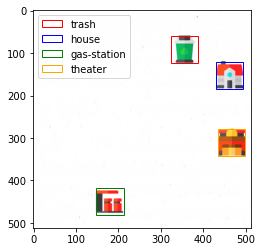

In [385]:
[templates, names] = load_training_images(ntraining_images)
pyramids = generate_pyramids(templates)
for i in range(20):
    detect_images(templates, names, pyramids, i)
    print(i)

In [386]:
#ntraining_images = 50
#[templates, names] = load_training_images(ntraining_images)
#pyramids = generate_pyramids(templates)
#show(pyramids[2][6])

In [387]:
#imgTest = cv2.cvtColor(cv2.imread("dataset1/test/images/test_image_3.png"), cv2.COLOR_BGR2GRAY)
#y = 141
#x = 121
#imgTest = imgTest[y:y + 64, x:x + 64]
#print(quicksimilarity(imgTest, pyramids[2][6]))
#newsize = round(len(imgTest) / 4)
#pyrascale = cv2.resize(pyramids[2][6], [newsize, newsize])
#testscale = cv2.resize(imgTest, [newsize, newsize])
#show(pyrascale)
#print(quicksimilarity(pyrascale, testscale))
